# Face Detection

Hello! In this task you will create your own deep face detector.

First of all, we need import some useful stuff.

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Do you have modern Nvidia [GPU](https://en.wikipedia.org/wiki/Graphics_processing_unit)? There is your video-card model in [list](https://developer.nvidia.com/cuda-gpus) and CUDA capability >= 3.0?

- Yes. You can use it for fast deep learning! In this work we recommend you use tensorflow backend with GPU. Read [installation notes](https://www.tensorflow.org/install/) with attention to gpu section, install all requirements and then install GPU version `tensorflow-gpu`.
- No. CPU is enough for this task, but you have to use only simple model. Read [installation notes](https://www.tensorflow.org/install/) and install CPU version `tensorflow`.

Of course, also you should install `keras`, `matplotlib`, `numpy` and `scikit-image`.

In [3]:
from keras import backend as K

Using TensorFlow backend.


In [4]:
from matplotlib import pyplot as plt
import numpy as np
from skimage import transform
import pickle
from tqdm import tqdm_notebook as tqdm

In [5]:
from get_data import load_dataset, unpack

In this task we use processed [FDDB dataset](http://vis-www.cs.umass.edu/fddb/). Processing defined in file [./prepare_data.ipynb](prepare_data.ipynb) and consists of:

1. Extract bboxes from dataset. In base dataset face defined by [ellipsis](http://vis-www.cs.umass.edu/fddb/samples/) that not very useful for basic neural network learning.
2. Remove images with big and small faces on one shoot.
3. Re-size images to bounding boxes (bboxes) have same size 32 +/- pixels.

Each image in train, validation and test datasets have shape (176, 176, 3), but part of this image is black background. Interesting image aligned at top left corner.

Bounding boxes define face in image and consist of 5 integer numbers: [image_index, min_row, min_col, max_row, max_col]. Bounding box width and height are 32 +/- 8 pixels wide.

`train_bboxes` and `val_bboxes` is a list of bboxes.

`train_shapes` and `val_shapes` is a list of interesting image shapes.

In [6]:
# First run will download 30 MB data from github

train_images, train_bboxes, train_shapes = load_dataset("data", "train")
val_images, val_bboxes, val_shapes = load_dataset("data", "val")

## Prepare data (1 point)

For learning we should extract positive and negative samples from image.
Positive and negative samples counts should be similar.
Every samples should have same size.

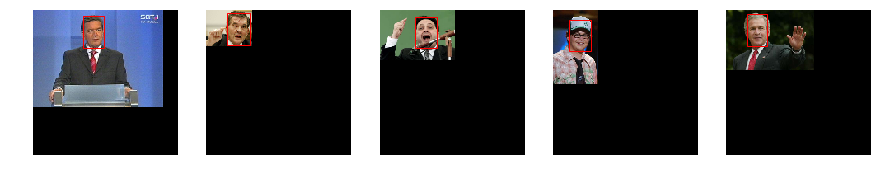

In [7]:
from graph import visualize_bboxes
visualize_bboxes(images=train_images,
                 true_bboxes=train_bboxes
                )

Every image can represent multiple faces, so we should extract all faces from every images and crop them to `SAMPLE_SHAPE`. This set of extracted images are named `positive`.

Then we chould extract `negative` set. This images should have `SAMPLE_SHAPE` size. Pseudocode for extracting:

    negative_collection := []

    for i in range(negative_bbox_count):
        Select random image.
        image_shape := image_shapes[image_index]
        image_true_bboxes := true_bboxes[true_bboxes[:, 0] == image_index, 1:]
        
        for j in TRY_COUNT: # TRY_COUNT is a magic constant, for example, 100
            Generate new_bbox within image_shape.
            
            if new_bbox is negative bbox for image_true_bboxes:
                Extract from image, new_bbox and resize to SAMPLE_SIZE negative_sample.
                Add negative sample to negative_collection.
                Break # for j in TRY_COUNT

In [8]:
SAMPLE_SHAPE = (32, 32, 3)

In [9]:
from scores import iou_score # https://en.wikipedia.org/wiki/Jaccard_index

def is_negative_bbox(new_bbox, true_bboxes, eps=1e-1):
    """Check if new bbox not in true bbox list.
    
    There bbox is 4 ints [min_row, min_col, max_row, max_col] without image index."""
    for bbox in true_bboxes:
        if iou_score(new_bbox, bbox) >= eps:
            return False
    return True

In [10]:
# Write this function
def gen_negative_bbox(image_shape, bbox_size, true_bboxes):
    """Generate negative bbox for image."""
    image_width, image_height = image_shape
    for j in range(100):
        x_start = np.random.randint(low=0, high=image_width - bbox_size[0])
        y_start = np.random.randint(low=0, high=image_height - bbox_size[1])
        bbox_width = np.random.randint(low=bbox_size[0], high=image_width - x_start)
        bbox_height = np.random.randint(low=bbox_size[1], high=image_height - y_start)
        new_bbox = [x_start, y_start, x_start + bbox_width, y_start + bbox_height]
        if is_negative_bbox(new_bbox, [true_bbox[1:] for true_bbox in true_bboxes]):
            return new_bbox
    return None

def get_positive_negative(images, true_bboxes, image_shapes, negative_bbox_count=None):
    """Retrieve positive and negative samples from image."""
    positive = []
    negative = []
    image_count = image_shapes.shape[0]
    
    if negative_bbox_count is None:
        negative_bbox_count = len(true_bboxes)
        
    def extract_positive_sample_from_image(image, bbox):
        assert(image.shape[2] == 3)
        x_center = (bbox[0] + bbox[2]) // 2
        y_center = (bbox[1] + bbox[3]) // 2
        x_start = max(0, x_center - SAMPLE_SHAPE[0] // 2)
        y_start = max(0, y_center - SAMPLE_SHAPE[1] // 2)
        x_end = x_start + SAMPLE_SHAPE[0]
        y_end = y_start + SAMPLE_SHAPE[1]
        assert(image.shape[0] > x_end and image.shape[1] > y_end)
        return np.array(image[x_start:x_end, y_start:y_end] / 255, dtype=np.float32)
    
    for i, true_bbox in enumerate(true_bboxes):
        assert(len(true_bbox) == 5)
        image_num = true_bbox[0]
        sample = extract_positive_sample_from_image(images[image_num], true_bbox[1:])
        assert(sample.shape == SAMPLE_SHAPE)
        positive.append(sample)
        
    def extract_negative_sample_from_image(image, bbox):
        cropped_image = image[bbox[0]:bbox[2], bbox[1]:bbox[3]]
        resized_image = transform.resize(cropped_image, SAMPLE_SHAPE) 
        return resized_image    
    
    for i in tqdm(range(negative_bbox_count)):
        while True:
            image_num = np.random.randint(low=0, high=len(images))
            negative_bbox = gen_negative_bbox(image_shapes[image_num], SAMPLE_SHAPE, true_bboxes)
            if negative_bbox is not None:
                break
        sample = extract_negative_sample_from_image(images[image_num], negative_bbox)
        assert(sample.shape == SAMPLE_SHAPE)
        negative.append(sample)

    max_positive = max([np.max(image) for image in positive])
    max_negative = max([np.max(image) for image in negative])
   
    return positive, negative

In [11]:
def get_samples(images, true_bboxes, image_shapes):
    """Usefull samples for learning.
    
    X - positive and negative samples.
    Y - one hot encoded list of zeros and ones. One is positive marker.
    """
    positive, negative = get_positive_negative(images=images, true_bboxes=true_bboxes, 
                                               image_shapes=image_shapes)
    X = positive
    Y = [[0, 1]] * len(positive)
    
    X.extend(negative)
    Y.extend([[1, 0]] * len(negative))
    
    return np.array(X), np.array(Y)

Now we can extract samples from images.

In [12]:
NEED_TO_GET_SAMPLES = False

variables_names = ["X_train", "Y_train", "X_val", "Y_val"]
if NEED_TO_GET_SAMPLES:
    X_train, Y_train = get_samples(train_images, train_bboxes, train_shapes)
    X_val, Y_val = get_samples(val_images, val_bboxes, val_shapes)
    variables = [X_train, Y_train, X_val, Y_val]
    for variable, variable_name in zip(variables, variables_names):
        with open(f"data/variables/{variable_name}.pickle", "wb") as file:
            pickle.dump(variable, file)
else:
    variables = []
    for variable_name in variables_names:
        with open(f"data/variables/{variable_name}.pickle", "rb") as file:
            variables.append(pickle.load(file))
    X_train, Y_train, X_val, Y_val = variables

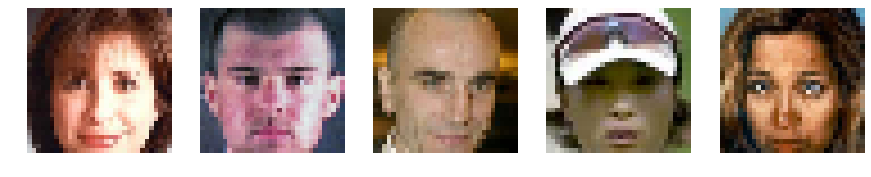

In [13]:
# There we should see faces
from graph import visualize_samples
visualize_samples(X_train[Y_train[:, 1] == 1])

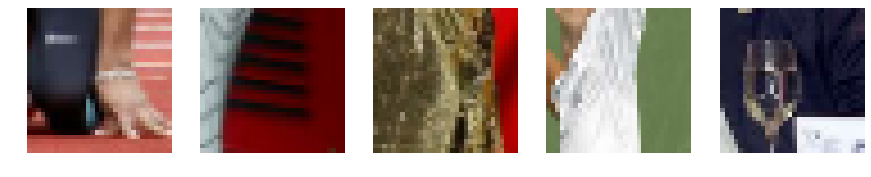

In [14]:
# There we shouldn't see faces
visualize_samples(X_train[Y_train[:, 1] == 0])

## Classifier training (3 points)

First of all, we should train face classifier that checks if face represented on sample.

In [15]:
BATCH_SIZE = 64

### Image augmentation

Important thing in deep learning is augmentation. Sometimes, if your model are complex and cool, you can increase quality by using good augmentation.

Keras provide good [images preprocessing and augmentation](https://keras.io/preprocessing/image/). This preprocessing executes online (on the fly) while learning.

Of course, if you want using samplewise and featurewise center and std normalization you should run this transformation on predict stage. But you will use this classifier to fully convolution detector, in this case such transformation quite complicated, and we don't recommend use them in classifier.

For heavy augmentation you can use library [imgaug](https://github.com/aleju/imgaug). If you need, you can use this library in offline manner (simple way) and online manner (hard way). However, hard way is not so hard: you only have to write [python generator](https://wiki.python.org/moin/Generators), which returns image batches, and pass it to [fit_generator](https://keras.io/models/model/#fit_generator)

In [16]:
from keras.preprocessing.image import ImageDataGenerator # Usefull thing. Read the doc.

datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.1,
                            )
datagen.fit(X_train)

### Fitting classifier

For fitting you can use one of Keras optimizer algorithms. [Good overview](http://ruder.io/optimizing-gradient-descent/)

To choose best learning rate strategy you should read about EarlyStopping and ReduceLROnPlateau or LearningRateScheduler on [callbacks](https://keras.io/callbacks/) page of keras documentation, it's very useful in deep learning.

If you repeat architecture from some paper, you can find information about good optimizer algorithm and learning rate strategy in this paper. For example, every [keras application](https://keras.io/applications/) has link to paper, that describes suitable learning procedure for this specific architecture.

In [17]:
import os.path
from keras.optimizers import Adam
# Very usefull, pay attention
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

from graph import plot_history


def fit(model, datagen, X_train, Y_train, X_val, Y_val, model_name=None, output_dir="data/checkpoints", 
        class_weight=None, epochs=50, lr=0.001, verbose=False):
    """Fit model.
    
    You can edit this function anyhow.
    """
    
    if verbose:
        model.summary()

    model.compile(optimizer=Adam(lr=lr), # You can use another optimizer
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    
    history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                                  validation_data=(datagen.standardize(X_val), Y_val),
                                  epochs=epochs, steps_per_epoch=len(X_train) // BATCH_SIZE,
                                  callbacks=[ModelCheckpoint(os.path.join(output_dir, "{model_name}").format(model_name=model_name) + "-{epoch:02d}-{val_loss:.2f}.hdf5", save_best_only=True),
                                            ] if model_name is not None else [],
                                  class_weight=class_weight,
                      
                                 )  # starts training
    
    plot_history(history)

#### (first point out of three)

![lenet architecture](lenet_architecture.png)
LeCun, Y., Bottou, L., Bengio, Y. and Haffner, P., 1998. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), pp.2278-2324.

Of course, you can use any another architecture, if want. Main thing is classification quality of your model.

Acceptable validation accuracy for this task is 0.92.

In [134]:
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation, Input, Dropout, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Softmax

In [52]:
def generate_model(sample_shape):
    # Classification model
    # You can start from LeNet architecture

    # Write code here
    model = Sequential()
    model.add(Conv2D(filters=6, kernel_size=(5, 5), activation="relu", input_shape=sample_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(5, 5), activation='relu'))
    model.add(Flatten())
    model.add(Dense(units=84, activation='relu'))
    model.add(Dense(units=2, activation = 'softmax'))
    return model

model = generate_model(SAMPLE_SHAPE)

#### Fit the model (second point out of three)

If you doesn't have fast video-card suitable for deep learning, you can first check neural network modifications with small value of parameter `epochs`, for example, 10, and then after selecting best model increase this parameter.
Fitting on CPU can be long, we suggest do it at bedtime.

Don't forget change model name.

Epoch 1/50
32/32 [==============================] - 2s 49ms/step - loss: 0.6349 - acc: 0.6196 - val_loss: 0.5583 - val_acc: 0.7787
Epoch 2/50
32/32 [==============================] - 1s 32ms/step - loss: 0.4399 - acc: 0.8404 - val_loss: 0.3637 - val_acc: 0.8655
Epoch 3/50
32/32 [==============================] - 1s 34ms/step - loss: 0.3438 - acc: 0.8634 - val_loss: 0.2918 - val_acc: 0.8866
Epoch 4/50
32/32 [==============================] - 1s 31ms/step - loss: 0.2645 - acc: 0.8997 - val_loss: 0.2375 - val_acc: 0.9230
Epoch 5/50
32/32 [==============================] - 1s 31ms/step - loss: 0.2276 - acc: 0.9102 - val_loss: 0.3149 - val_acc: 0.8782
Epoch 6/50
32/32 [==============================] - 1s 29ms/step - loss: 0.2337 - acc: 0.9180 - val_loss: 0.2296 - val_acc: 0.9258
Epoch 7/50
32/32 [==============================] - 1s 31ms/step - loss: 0.2034 - acc: 0.9258 - val_loss: 0.2083 - val_acc: 0.9300
Epoch 8/50
32/32 [==============================] - 1s 30ms/step - loss: 0.2086 - a

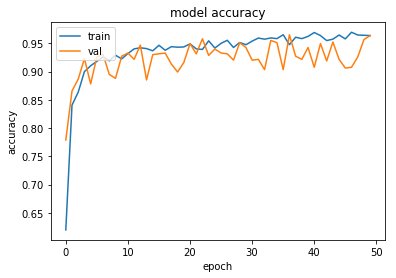

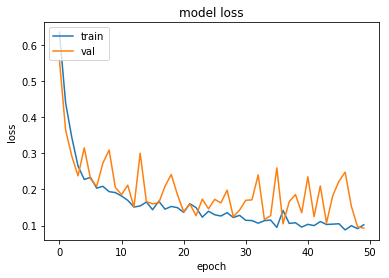

In [53]:
# Attention: Windows implementation may cause an error here. In that case use model_name=None.
fit(model_name="lenet", model=model, datagen=datagen, 
    X_train=X_train, X_val=X_val, Y_train=Y_train, Y_val=Y_val,
    lr=0.0005)

#### (third point out of three)

After learning model weights saves in folder `data/checkpoints/`.
Use `model.load_weights(fname)` to load best weights.

If you use Windows and Model Checkpoint doesn't work on your configuration, you should implement [your own Callback](https://keras.io/callbacks/#create-a-callback) to save best weights in memory and then load it back.

In [61]:
def get_checkpoint():
    return "data/checkpoints/lenet-50-0.09.hdf5"

model.load_weights(get_checkpoint())

## Detection

If you have prepared classification architecture with high validation score, you can use this architecture for detection.

Convert classification architecture to fully convolution neural network (FCNN), that returns heatmap of activation.

### Detector model or sliding window (1 point)

Now you should replace fully-connected layers with $1 \times 1$ convolution layers.

Every fully connected layer perform operation $f(Wx + b)$, where $f(\cdot)$ is nonlinear activation function, $x$ is layer input, $W$ and $b$ is layer weights. This operation can be emulated with $1 \times 1$ convolution with activation function $f(\cdot)$, that perform exactly same operation $f(Wx + b)$.

If there is `Flatten` layer with $n \times k$ input size before fully connected layers, convolution should have same $n \times k$ input size.
Multiple fully connected layers can be replaced with convolution layers sequence.

After replace all fully connected layers with convolution layers, we get fully convolution network. If input shape is equal to input size of previous network, output will have size $1 \times 1$. But if we increase input shape, output shape automatically will be increased. For example, if convolution step of previous network strides 4 pixels, increase input size with 100 pixels along all axis makes increase outputsize with 25 values along all axis. We got activation map of classifier without necessary extract samples from image and multiple calculate low-level features.

In total:
1. $1 \times 1$ convolution layer is equivalent of fully connected layer.
2. $1 \times 1$ convolution layers can be used to get activation map of classification network in "sliding window" manner.

We propose replace last fully connected layer with softmax activation to convolution layer with linear activation.It will be usefull to find good treshold. Of course, you can use softmax activation.

#### Example of replace cnn head:

##### Head before convert

![before replace image](before_convert.png)

##### Head after convert

![before replace image](after_convert.png)

On this images displayed only head. `InputLayer` should be replaced with convolution part exit.
Before convert network head takes fifty $8 \times 8$ feature maps and returns two values: probability of negative and positive classes. This output can be considered as activation map with size $1 \times 1$.

If input have size $8 \times 8$, output after convert would have $1 \times 1$ size, but input size is $44 \times 44$.
After convert network head returns one $37 \times 37$ activation map.

In [141]:
# FCNN

IMAGE_SHAPE = (176, 176, 3)

def generate_fcnn_model(image_shape):
    """After model compilation input size cannot be changed.
    
    So, we need create a function to have ability to change size later.
    """
    # Write code here
    model = Sequential()
    model.add(Conv2D(filters=6, kernel_size=(5, 5), activation="relu", input_shape=image_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(5, 5), activation='relu'))
    
    model.add(Conv2D(filters=84, kernel_size=(1, 1), activation="relu"))
    model.add(Conv2D(filters=2, kernel_size=(1, 1), activation="linear"))
#     model.add(Softmax(axis=3))
    return model

fcnn_model = generate_fcnn_model(IMAGE_SHAPE)

In [142]:
fcnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 172, 172, 6)       456       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 86, 86, 6)         0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 82, 82, 16)        2416      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 41, 41, 16)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 8, 8, 32)          12832     
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 8, 8, 84)          2772      
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 8, 8, 2)           170       
Total para

#### (1 point)

Then you should write function that copy weights from classification model to fully convolution model.
Convolution weights may be copied without modification, fully-connected layer weights should be reshaped before copy.

Pay attention to last layer.

In [143]:
def copy_weights(base_model, fcnn_model):
    """Set FCNN weights from base model.
    """
    
    new_fcnn_weights = []
    prev_fcnn_weights = fcnn_model.get_weights()
    prev_base_weights = base_model.get_weights()
    
    for base_weight, fcnn_weight in zip(prev_base_weights, prev_fcnn_weights):
        if base_weight.shape == fcnn_weight.shape:
            new_fcnn_weights.append(base_weight.copy())
        else:
            new_weight = base_weight.copy().reshape((1, 1) + base_weight.shape)
            assert(new_weight.shape == fcnn_weight.shape)
            new_fcnn_weights.append(new_weight)
        
    fcnn_model.set_weights(new_fcnn_weights)

copy_weights(base_model=model, fcnn_model=fcnn_model)

### Model visualization

In [144]:
from graph import visualize_heatmap

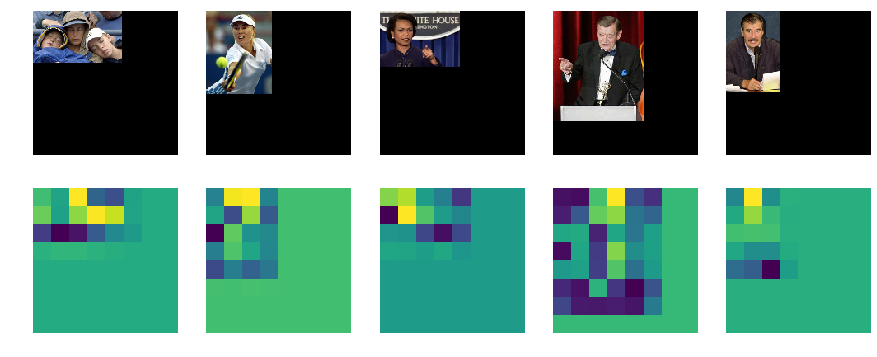

In [145]:
predictions = fcnn_model.predict(np.array(val_images))
visualize_heatmap(val_images, predictions[:, :, :, 1])

### Detector (1 point)

First detector part is getting bboxes and decision function.
Greater decision function indicates better detector confidence.

This function should return pred_bboxes and decision_function:

- `pred bboxes` is list of 5 int tuples like `true bboxes`: `[image_index, min_row, min_col, max_row, max_col]`.
- `decision function` is confidence of detector for every pred bbox: list of float values, `len(decision function) == len(pred bboxes)` 
 
We propose resize image to `IMAGE_SHAPE` size, find faces on resized image with `SAMPLE_SHAPE` size and then resize them back.

In [115]:
from scipy.special import softmax

In [132]:
# Detection
from skimage.feature import peak_local_max

def get_bboxes_and_decision_function(fcnn_model, images, image_shapes):      
    cropped_images = np.array([transform.resize(image, IMAGE_SHAPE, mode="reflect")  if image.shape != IMAGE_SHAPE else image for image in images])
    pred_bboxes, decision_function = [], []
   
    # Predict
    predictions = fcnn_model.predict(cropped_images)
    predictions = softmax(predictions, axis=3)

    # Write code here
    for image_index, prediction in enumerate(predictions):
        prediction = prediction[..., 1]
        plt.imshow(images[image_index])
        plt.show()
        plt.imshow(prediction)
        plt.colorbar()
        plt.show()
        local_maxs = peak_local_max(prediction)
        for local_max in local_maxs:
            confidence = prediction[local_max[0], local_max[1]]
            if prediction[local_max[0], local_max[1]] <= 1e-8:
                continue
            print(local_max, prediction[local_max[0], local_max[1]])
        if image_index == 0:
            break
        
    return pred_bboxes, decision_function

#### Detector visualization

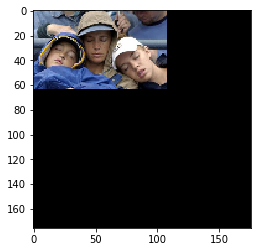

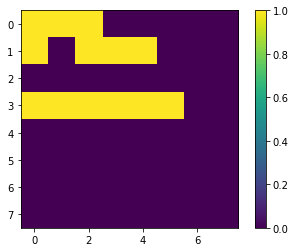

[6 6] 0.0006991725
[6 5] 0.0006991725
[6 4] 0.0006991725
[6 3] 0.0006991725
[6 2] 0.0006991725
[6 1] 0.0006991725
[5 6] 0.0006991725
[5 5] 0.0006991725
[5 4] 0.0006991725
[5 3] 0.0006991725
[5 2] 0.0006991725
[5 1] 0.0006991725
[3 4] 1.0
[3 3] 1.0
[3 2] 1.0
[3 1] 1.0
[1 6] 0.0006991725
[1 4] 1.0
[1 3] 1.0
[1 2] 1.0


In [133]:
pred_bboxes, decision_function = get_bboxes_and_decision_function(fcnn_model=fcnn_model, images=val_images, image_shapes=val_shapes)

# visualize_bboxes(images=val_images,
#                  pred_bboxes=pred_bboxes,
#                  true_bboxes=val_bboxes,
#                  decision_function=decision_function
#                 )

## Detector score (1 point)

Write [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) graph.

You can use function `best_match` to extract matching between prediction and ground truth, false positive and false negative samples. Pseudo-code for calculation precision and recall graph:
    
    # Initialization for first step threshold := -inf
    tn := 0 # We haven't any positive sample
    fn := |false_negative| # But some faces wasn't been detected
    tp := |true_bboxes| # All true bboxes have been caught
    fp := |false_positive| # But also some false positive samples have been caught
    
    Sort decision_function and pred_bboxes with order defined by decision_function
    y_true := List of answers for "Is the bbox have matching in y_true?" for every bbox in pred_bboxes
    
    for y_on_this_step in y_true:
        # Now we increase threshold, so some predicted bboxes makes positive.
        # If y_t is True then the bbox is true positive else bbox is false positive
        # So we should
        Update tp, tn, fp, fn with attention to y_on_this_step
        
        Add precision and recall point calculated by formula through tp, tn, fp, fn on this step
        Threshold for this point is decision function on this step.

In [ ]:
from scores import best_match
from graph import plot_precision_recall

def precision_recall_curve(pred_bboxes, true_bboxes, decision_function):
    precision, recall, thresholds = [], [], []
    
    # Write code here
    
    return precision, recall, thresholds

In [ ]:
precision, recall, thresholds = precision_recall_curve(pred_bboxes=pred_bboxes, true_bboxes=val_bboxes, decision_function=decision_function)
plot_precision_recall(precision=precision, recall=recall)

### Threshold (1 point)

Next step in detector creating is select threshold for decision_function.
Every possible threshold presents point on recall-precision graph.

Select threshold for `recall=0.85`.

In [ ]:
def get_threshold(thresholds, recall):
    return ... # Write this code

THRESHOLD = get_threshold(thresholds, recall)

In [ ]:
def detect(fcnn_model, images, image_shapes, threshold, return_decision=True):
    """Get bboxes with decision_function not less then threshold."""
    pred_bboxes, decision_function = get_bboxes_and_decision_function(fcnn_model, images, image_shapes)   
    result, result_decision = [], []
    
    # Write code here
    # ...
    
    if return_decision:
        return result, result_decision
    else:
        return result

In [ ]:
pred_bboxes, decision_function = detect(fcnn_model=fcnn_model, images=val_images, image_shapes=val_shapes, threshold=THRESHOLD, return_decision=True)

visualize_bboxes(images=val_images,
                 pred_bboxes=pred_bboxes,
                 true_bboxes=val_bboxes,
                 decision_function=decision_function
                )

precision, recall, thresholds = precision_recall_curve(pred_bboxes=pred_bboxes, true_bboxes=val_bboxes, decision_function=decision_function)
plot_precision_recall(precision=precision, recall=recall)

## Test dataset (1 point)

Last detector preparation step is testing.

Attention: to avoid over-fitting, after testing algorithm you should run [./prepare_data.ipynb](prepare_data.ipynb), and start all fitting from beginning.

Detection score (in graph header) should be 0.85 or greater.

In [ ]:
test_images, test_bboxes, test_shapes = load_dataset("data", "test")

# We test get_bboxes_and_decision_function becouse we want pay attention to all recall values
pred_bboxes, decision_function = get_bboxes_and_decision_function(fcnn_model=fcnn_model, images=test_images, image_shapes=test_shapes)

visualize_bboxes(images=test_images,
                 pred_bboxes=pred_bboxes,
                 true_bboxes=test_bboxes,
                 decision_function=decision_function
                )

precision, recall, threshold = precision_recall_curve(pred_bboxes=pred_bboxes, true_bboxes=test_bboxes, decision_function=decision_function)
plot_precision_recall(precision=precision, recall=recall)

## Optional tasks

### Real image dataset

Test your algorithm on original (not scaled) data.
Visualize bboxes and plot precision-recall curve.

In [ ]:
# First run will download 523 MB data from github

original_images, original_bboxes, original_shapes = load_dataset("data", "original")

In [ ]:
# Write code here
# ...


## Hard negative mining

Upgrade the score with [hard negative mining](https://www.reddit.com/r/computervision/comments/2ggc5l/what_is_hard_negative_mining_and_how_is_it/).

A hard negative is when you take that falsely detected patch, and explicitly create a negative example out of that patch, and add that negative to your training set. When you retrain your classifier, it should perform better with this extra knowledge, and not make as many false positives.

In [ ]:
# Write this function
def hard_negative(train_images, image_shapes, train_bboxes, X_val, Y_val, base_model, fcnn_model):
    pass

In [ ]:
hard_negative(train_images=train_images, image_shapes=train_shapes, train_bboxes=train_bboxes, X_val=X_val, Y_val=Y_val, base_model=model, fcnn_model=fcnn_model)

In [ ]:
model.load_weights("data/checkpoints/...")

In [ ]:
copy_weights(base_model=model, fcnn_model=fcnn_model)

pred_bboxes, decision_function = get_bboxes_and_decision_function(fcnn_model=fcnn_model, images=val_images, image_shapes=val_shapes)

visualize_bboxes(images=val_images,
                 pred_bboxes=pred_bboxes,
                 true_bboxes=val_bboxes,
                 decision_function=decision_function
                )

precision, recall, thresholds = precision_recall_curve(pred_bboxes=pred_bboxes, true_bboxes=val_bboxes, decision_function=decision_function)
plot_precision_recall(precision=precision, recall=recall)

### Multi scale detector

Write and test detector with [pyramid representation][pyramid].
[pyramid]: https://en.wikipedia.org/wiki/Pyramid_(image_processing)

1. Resize images to predefined scales.
2. Run detector with different scales.
3. Apply non-maximum supression to detection on different scales.

References:
1. [E. H. Adelson,C. H. Anderson, J. R. Bergen, P. J. Burt, J. M. Ogden: Pyramid methods in image processing](http://persci.mit.edu/pub_pdfs/RCA84.pdf)
2. [PETER J. BURT, EDWARD H. ADELSON: The Laplacian Pyramid as a Compact Image Code](http://persci.mit.edu/pub_pdfs/pyramid83.pdf)

In [ ]:
def multiscale_detector(fcnn_model, images, image_shapes):
    return []

### Next  step

Next steps in deep learning detection are R-CNN, Faster R-CNN and SSD architectures.
This architecture realization is quite complex.
For this reason the task doesn't cover them, but you can find the articles in the internet.